In [115]:
import os
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict, namedtuple
from io import StringIO
import re
from sklearn.feature_selection import mutual_info_regression
from IPython.display import display, Latex
from functools import reduce

## reading results

In [110]:
def group_files(res_path):
    # group file names by configuration
    results_by_specs = defaultdict(list)
    for fname in os.listdir(res_path):
        if not fname.endswith('.txt'):
            continue

        try:
            spec, day, hour = fname[:-len('.txt')].split('-')
            
            if 'MOSTEstimator' in fname:
                _, model, most, cvk = spec.split('_')
                features = 'zL'
                trend = '-'
            else:
                _, model, features, trend, most, cvk = spec.split('_')
        except:
            print('bad name:', fname)
            continue

        results_by_specs[(model, features, trend, most, cvk)].append(fname)

    spec_cols = ['estimator', 'features', 'trend', 'most', 'cvk']

    return results_by_specs, spec_cols


def parse_result_file(res_path, res_file, section_name):
    res_lines, found = [], False
    with open(os.path.join(res_path, res_file)) as f:
        for i, row in enumerate(f):
            rr = row.strip()

            if found and not rr.startswith('**'):
                res_lines.append(rr)
            elif found and rr.startswith('**'):
                break
            elif not found and rr.startswith('**' + section_name):
                found = True

    if not found:
        raise RuntimeError('section %s not found in file %s' % (section_name, res_file))
    elif not res_lines:
        raise RuntimeError('section %s is empty in file %s' % (section_name, res_file))

    csv_text = re.sub('[ \t]+', ',', '\n'.join(res_lines))
    section_df = pd.read_csv(StringIO(csv_text))

    rows =[
        [i + 1, col, val,]
        for col in section_df
        for i, val in enumerate(section_df[col])
    ]
    
    cols = ['trial', 'column', 'value',]
        
    return rows, cols


def get_results(res_path, section_name):
    results_by_specs, spec_cols = group_files(res_path)
    
    df_rows, df_cols = [], None
    for spec, files in results_by_specs.items():
        latest_fname = list(sorted(files))[-1]
        for fname in files:
            rows, cols = parse_result_file(res_path, fname, section_name)

            df_rows.extend([
                list(spec) + rr + [fname == latest_fname]
                for rr in rows
            ])
            cols = spec_cols + cols + ['is_latest']
            
            if not df_cols:
                df_cols = cols
            else:
                assert df_cols == cols

    results = pd.DataFrame(df_rows, columns=df_cols)
    return results


long_to_short_metric = {
    'mean_squared_error': 'MSE',
    'median_squared_error': 'mSE',
    'mean_absolute_error': 'MAE',
    'median_absolute_error': 'mAE',
    'mean_abs_percent_error': 'MAPE',
    'median_abs_percent_error': 'mAPE',
    'r2_score': '$R^2$',
    'train_mse': 'Train MSE',
}


short_to_long_metric = {
    v: k for k, v in long_to_short_metric.items()
}


def rename(df):
    return df[
        (df.column != 'explained_variance_score')
    ].replace({
        'most': {'most': 'MOST', 'nomost': 'Full'},
        'trend': {'trend': 'Y', 'notrend': 'N'},
        'estimator': {
            'KNeighborsRegressor': 'kNN',
            'GradientBoostingRegressor': 'GBT',
            'MOSTEstimator': 'MOST',
        },
        'column': long_to_short_metric,
        'features': {'f1': 'F1', 'f2': 'F2', 'f3': 'F3', 'f4': 'F4', 'f5': 'F5'},
    }).rename(columns={
        'trial': 'Outer Fold',
        'features': 'Features',
        'column': 'Metric',
        'trend': 'Trend',
        'most': 'Dataset',
        'estimator': 'Model',
    })


res = rename(get_results('dev/results', 'raw scores'))
res.head(5)

,Model,Features,Trend,Dataset,cvk,Outer Fold,Metric,value,is_latest
0,GBT,F1,N,MOST,0outercv,1,Train MSE,0.183077,False
1,GBT,F1,N,MOST,0outercv,2,Train MSE,0.186880,False
2,GBT,F1,N,MOST,0outercv,3,Train MSE,0.186505,False
3,GBT,F1,N,MOST,0outercv,4,Train MSE,0.181897,False
4,GBT,F1,N,MOST,0outercv,5,Train MSE,0.182580,False


In [3]:
paras = rename(get_results('dev/results', 'raw parameters'))
paras.head(5)

,Model,Features,Trend,Dataset,cvk,Outer Fold,Metric,value,is_latest
0,GBT,F1,N,MOST,0outercv,1,alpha,0.396273,False
1,GBT,F1,N,MOST,0outercv,2,alpha,0.396273,False
2,GBT,F1,N,MOST,0outercv,3,alpha,0.396273,False
3,GBT,F1,N,MOST,0outercv,4,alpha,0.396273,False
4,GBT,F1,N,MOST,0outercv,5,alpha,0.396273,False


In [198]:
def paint_boxplot(bplot, all_color=None, **kwargs):
    # use all_color to paing all elements of the same color
    # or specify color for each element in kwargs
    # kwargs take precedence over all_color
    #
    # NB available elements are
    # boxes, medians, whiskers, caps, fliers, means

    for key in bplot:
        color = kwargs.get(key, all_color)
        if color:
            for element in bplot[key]:
                element.set_color(color)


def make_base_plot(res, model, dataset, cvk, metric, save_path=None, plot_all=True,
                   show_legend=False, show_baseline=True):
    
    plot_data, found = [], False
    fig, ax = plt.subplots()

    for features in range(1, 6):
        for tidx, trend in enumerate(['Y', 'N']):
            vals = res[
                (res.Model == model) &
                (res.Dataset == dataset) &
                (res.Features == 'F%d' % features) &
                (res.Trend == trend) & 
                (res.Metric == metric) &
                (res.cvk == cvk)
            ]['value'].values

            if vals.size == 0:
                plot_data.append([])
                continue

            if plot_all:
                plt.scatter([3 * (features - 1) + tidx] * len(vals), vals,
                            color='C%d' % tidx, s=7, zorder=10, marker='o')

            plot_data.append(vals)
            found = True

    if not found:
        print('no results for model %s on metric %s with dataset %s' % (
            model, metric, dataset
        ))
        return None, None
    
    boxplot_kwargs = {
        'showmeans': True,
        'patch_artist': False,
        'zorder': 5,
        'showfliers': not plot_all,
    }
    
    # trend
    bp1 = ax.boxplot(plot_data[::2], positions=range(0, 15, 3),
                     sym='C0.', **boxplot_kwargs)
    paint_boxplot(bp1, 'C0')

    # no trend
    bp2 = ax.boxplot(plot_data[1::2], positions=range(1, 15, 3),
                     sym='C1.', **boxplot_kwargs)
    paint_boxplot(bp2, 'C1')

    if show_baseline:
        most_data = res[
            (res.Model == 'MOST') &
            (res.Dataset == dataset) &
            (res.Metric == metric)
        ]

        bpm = ax.boxplot(most_data.value, positions=[-2], sym='k.',
                         widths=[0.5], **boxplot_kwargs)
        paint_boxplot(bpm, 'k')
        
        if plot_all:
            plt.scatter([-2] * len(most_data), most_data.value,
                        color='k', s=7, zorder=10, marker='o')

    if show_legend:
        old_ylim = ax.get_ylim()
        legend_lines = [
            ax.plot([], [], c='C0')[0],
            ax.plot([], [], c='C1')[0],
        ]
        
        legend_labels = ['Trend', 'No Trend']
        
        if show_baseline:
            legend_lines.append(ax.plot([], [], c='k')[0])
            legend_labels.append('MOST')
        
        ax.legend(legend_lines, legend_labels)
        ax.set_ylim(old_ylim)
    
    ax.margins(y=0.05)
    ax.set_xlabel('Feature Set')
    ax.set_ylabel(metric)
    if show_baseline:
        ax.set_xlim(-3, 14)
        ax.set_xticks([-2, 0.5, 3.5, 6.5, 9.5, 12.5])
        ax.set_xticklabels(['B', 'F1', 'F2', 'F3', 'F4', 'F5'])
    else:
        ax.set_xlim(-1, 14)
        ax.set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
        ax.set_xticklabels(['F1', 'F2', 'F3', 'F4', 'F5'])

    fig.tight_layout()
    
    if save_path is not None:
        if not save_path.endswith('.png'):
            most = 'most' if dataset == 'MOST' else 'nomost'
            column = short_to_long_metric[metric]
            save_path = os.path.join(
                save_path, 'result_%s_%s_%s.png' % (
                    model, most, column
                )
            )
            
        fig.savefig(save_path)
    
    # show the title on the notebook but not in the saved figure
    ax.set_title(
        model +
        ' - ' + '%s dataset' % dataset +
        ' - ' + metric
    )

    return fig, ax

## preparations for export 

In [239]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


def table_newline(text):
    # \\ expects an optional argument, such as '[' (???)
    # without this, a bracket after a newline would break everything
    return '\makecell[c]{%s}' % text.replace('\n', r'\\\relax')


def latex_bold(s):
    return r'\textbf{%s}' % s


def df_to_latex(df, vertical_space='1ex', column_align='c', fill_page_width=True,
                save_to=None, clear_index_name=True, multirow_pad='0.75ex',
                remove_empty_rows=True):
    
    df = df.copy()
    
    for i, row in enumerate(df.values):
        for j, content in enumerate(row):
            if isinstance(content, str) and '\n' in content:
                df.values[i, j] = table_newline(content)
    
    if clear_index_name:  # otherwise first row will be included in the table header
        df.index.name = ''

    if len(column_align) == 1:
        column_align = column_align * len(df.columns)

    # make bold column names
    # if multiindex then pandas will do it for us
    if not isinstance(df.columns, pd.MultiIndex):
        df.columns = list(map(latex_bold, df.columns))

    latex = '\\centering' + df.to_latex(
        escape=False,
        bold_rows=True,
        column_format='asd' if fill_page_width else column_align,
        multirow=True,
    )

    # replace double clines with a single hline
    latex = re.sub(r'\\cline{.*?}\n\\cline{.*?}', '\hline', latex)

    if vertical_space:
        # add vertical space between cells
        latex = (
            '\setcellgapes{%s}\makegapedcells' % vertical_space
        ) + latex

    # if we used makecell to insert newlines inside each cell, we have
    # to double the vertical size of the multirows
    # also move column name slightly upwards to make it aligned with center line
    # (move up by 1ex and down by 0.15ex to balance the padding)
    latex = re.sub(
        r'\\multirow{(\d+)}{\*}{(.*?)}', 
        lambda m: r'\multirowcell{%d}[%s][c]{%s}' % (
            2 * int(m[1]), multirow_pad, m[2]
        ), latex
    )

    # make multicolumns center aligned
    latex = re.sub(
        r'\\multicolumn{(\d+)}{\w}{(.*?)}',
        lambda m: r'\multicolumn{%s}{c}{%s}' % (
            m[1], m[2]
        ), latex
    )
    
    if remove_empty_rows:
        latex = '\n'.join(
            row for row in latex.split('\n')
            if any(c not in '& \t\\' for c in row)
        )
    
    if fill_page_width:
        # use tabular* environment to make table fill the page width
        latex = latex.replace(
            r'\begin{tabular}{asd}',
            r'\begin{tabular*}{\textwidth}{%s}' % (
                column_align.replace('|', r'|@{\extracolsep{\fill}}')
            )
        ).replace(r'\end{tabular}', r'\end{tabular*}')
    
    if save_to:
        with open(save_to, 'w') as f:
            f.write(latex)

    return latex

## generation of effect sizes

In [6]:
class WinsorEffectSize:
    def __init__(self, winsor, direction=1):
        self.winsor = winsor
        self.direction = np.sign(direction)
    
    def compute(self, control, treatment):
        tmc = stats.trim_mean(control, self.winsor)
        tmt = stats.trim_mean(treatment, self.winsor)
        
        wsc = stats.mstats.winsorize(control, self.winsor).std()
        wst = stats.mstats.winsorize(treatment, self.winsor).std()

        es = (tmt - tmc) / wst
        corr = (1 - 2 * self.winsor)
        
        return self.direction * corr * es


class CommonLanguageEffectSize:
    def __init__(self, direction=1):
        self.direction = direction
        
    def compute(self, control, treatment):
        supporting = count = 0
        for xc in control:
            for xt in treatment:
                count += 1
                if (
                    self.direction > 0 and xt > xc
                ) or (
                    self.direction < 0 and xt < xc
                ):
                    supporting += 1

        es = supporting / count
        return es


class BootstrapCIResult:
    def __init__(self, bootstraps):
        self.bootstraps = bootstraps

    def get_point_estimate(self, trim=0.2):
        return stats.trim_mean(self.bootstraps, trim)

    def get_percentile(self, alpha):
        return np.percentile(self.bootstraps, 100 * alpha)
    
    def get_ci(self, alpha_right, alpha_left):
        if alpha_left and 0.0 < alpha_left < 1.0:
            cihi = self.get_percentile(alpha_left)
        else:
            cihi = -np.inf

        if alpha_right and 0.0 < alpha_right < 1.0:
            cilo = self.get_percentile(alpha_right)
        else:
            cilo = np.inf
    
        return cilo, cihi
    
    def to_string(self, alpha_right=None, alpha_left=None,
                  float_format='%.1f'):
        cilo, cihi = self.get_ci(alpha_right, alpha_left)
        ci_left = np.isfinite(cilo)
        ci_right = np.isfinite(cihi)        
        point = self.get_point_estimate()

        if ci_left and ci_right:
            fmt = '{0} [{0},{0}]'.format(float_format)
            return fmt % (point, cilo, cihi)
        elif ci_left and not ci_right:
            fmt = '[{0}, {0}'.format(float_format)
            return fmt % (cilo, point)
        elif not ci_left and ci_right:
            fmt = '{0}, {0}]'.format(float_format)
            return fmt % (point, cihi)
        else:
            fmt = '%s' % float_format
            return fmt % point

    
def compute_effect_size(control, treatment, compute_effect_size,
                        bootstrap_repeats=1000):

    es = compute_effect_size or WinsorEffectSize(winsor, direction)
    effect_sizes = []
    for i in range(bootstrap_repeats):
        control_sample = np.random.choice(control, len(control))
        treatment_sample = np.random.choice(treatment, len(treatment))

        effect_sizes.append(es.compute(control_sample, treatment_sample))

    return BootstrapCIResult(effect_sizes)

graphical demonstration on why we normalize by the standard deviation of the treatment

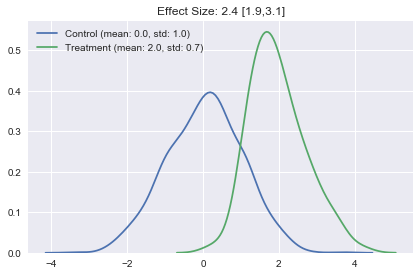

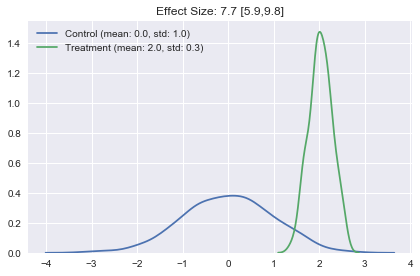

In [27]:
def show_effect_size(control, treatment, save_path=None):
    es = compute_effect_size(control, treatment, WinsorEffectSize(0.2, 1))
    plt.title('Effect Size: %s' % es.to_string(0.025, 0.975))
    sns.kdeplot(control, label='Control (mean: %.1f, std: %.1f)' % (control.mean(), control.std()))
    sns.kdeplot(treatment, label='Treatment (mean: %.1f, std: %.1f)' % (treatment.mean(), treatment.std()))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


show_effect_size(np.random.normal(0, 1, size=1000),
                 np.random.normal(2, 0.75, size=100),
                 'manuscript/images/small_es.png')


show_effect_size(np.random.normal(0, 1, size=1000),
                 np.random.normal(2, 0.25, size=100),
                 'manuscript/images/large_es.png')

# comparison with baseline

compare each estimator with most baseline, select best performing features and trend

comparison is done on the results obtained with **nested** cross-validation

In [12]:
best_res = res[
    (res.cvk == '10outercv') &
    (res.Metric == 'MSE') &
    (res.is_latest)
].merge(best, on=['Dataset', 'Model'])
best_res = best_res[
    (best_res.Features == best_res.best_feat) &
    (best_res.Trend == best_res.best_trend)
]
best_res.head()

,Model,Features,Trend,Dataset,cvk,Outer Fold,Metric,value,is_latest,best_feat,best_trend
50,GBT,F3,Y,MOST,10outercv,1,MSE,0.149224,True,F3,Y
51,GBT,F3,Y,MOST,10outercv,2,MSE,0.172257,True,F3,Y
52,GBT,F3,Y,MOST,10outercv,3,MSE,0.171872,True,F3,Y
53,GBT,F3,Y,MOST,10outercv,4,MSE,0.186999,True,F3,Y
54,GBT,F3,Y,MOST,10outercv,5,MSE,0.190797,True,F3,Y


In [20]:
plot_data[plot_data.Model == 'GBT']

,Model,level_1,MOST,Full
0,GBT,0,0.180621,0.309631
1,GBT,1,0.165647,0.358092
2,GBT,2,0.180849,0.369686
3,GBT,3,0.168931,0.424221
4,GBT,4,0.158289,0.370486
5,GBT,5,0.217597,0.334151
6,GBT,6,0.182249,0.400681
7,GBT,7,0.159061,0.343399
8,GBT,8,0.161170,0.315853
9,GBT,9,0.175365,0.403964


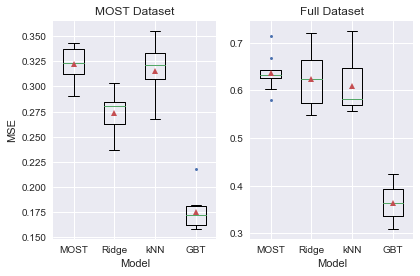

In [202]:
plot_data = res[
     ((res.Features.isin(('f9', 'zL'))))
     & (res.cvk == '10outercv')
     & (res.Trend != 'Y')
     & (res.Metric == 'MSE')
     & res.is_latest
].groupby('Model').apply(
    lambda g: pd.DataFrame([
        g[g.Dataset == 'MOST'].value.values,
        g[g.Dataset == 'Full'].value.values,
    ], index=['MOST', 'Full']).T
).reset_index()

sorted_models = ['MOST', 'Ridge', 'kNN', 'GBT']


def bplot(ax, data, pos):
    ax.boxplot(data, positions=[pos], widths=[0.5],
               sym='C0.', showmeans=True)


fig, ax = plt.subplots(1, 2)
for i, model in enumerate(sorted_models):
    bplot(ax[0], plot_data[plot_data.Model == model].MOST, i)
    bplot(ax[1], plot_data[plot_data.Model == model].Full, i)


def fixax(ax):
    ax.set_xticks(list(range(4)))
    ax.set_xticklabels(sorted_models)
    ax.set_xlim(-0.5, 3.5)
    ax.set_xlabel('Model')

fixax(ax[0])
fixax(ax[1])

plt.suptitle('')
ax[0].set_ylabel('MSE')
ax[0].set_title('MOST Dataset')
ax[1].set_title('Full Dataset')
plt.tight_layout()
plt.savefig('manuscript/images/baseline_comparison.png')

In [114]:
most_data = res[
    (res.Metric == 'MSE') &
    (res.Model == 'MOST') &
    (res.cvk == '10outercv') &
    (res.is_latest)
]


def summarize(group):
    assert len(group.Dataset.unique()) == 1
    dataset = group.Dataset.values[0]
    
    assert len(group.Model.unique()) == 1
    model = group.Model.values[0]
    
    if model != 'MOST':
        es = compute_effect_size(
            most_data[most_data.Dataset == dataset].value,
            group.value, WinsorEffectSize(0.2, -1)
        )
        
        es_str = es.to_string(0.05, None)
        if es.get_percentile(0.05) > 0:
            es_str = latex_bold(es_str)
    else:
        es_str = '-'
    
    stats = group.value.describe(
        percentiles=[0.5]
    ).drop('count').apply(
        lambda x: '%.2f' % x if isinstance(x, float) else x
    )
    
    return stats.append(pd.Series([es_str], index=['es']))


summary = res[
    (res.cvk == '10outercv') &
    (res.Metric == 'MSE') &
    (res.is_latest) &
    res.Features.isin(('f9', 'zL')) &
    res.Trend.isin(('N', '-'))
].groupby([
    'Dataset', 'Model'
]).apply(
    summarize
).rename(columns={
    'feat': 'Feat.',
    'trend': 'Trend',
    'mean': 'Mean',
    'std': 'Std.',
    'min': 'Min.',
    'max': 'Max.',
    '50%': '50\%',
    'es': 'Effect Size',
}).reindex([
    'MOST', 'GBT', 'kNN', 'Ridge',
], level=1)


#summary.columns.name = ''

df_to_latex(summary, column_align='cr|cccccccc', clear_index_name=False,
            multirow_pad='3.75ex', save_to='manuscript/include/baseline_comparison.tex')

summary

C:\Users\edo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Mean  Std.  Min.  50\%  Max.          Effect Size
Dataset Model                                                   
Full    MOST   0.64  0.04  0.58  0.63  0.71  -                  
        GBT    0.36  0.04  0.31  0.36  0.42  \textbf{[4.2, 7.2} 
        kNN    0.61  0.05  0.56  0.58  0.73  [-0.1, 0.6         
        Ridge  0.62  0.06  0.55  0.62  0.72  [-0.5, 0.2         
MOST    MOST   0.32  0.02  0.29  0.32  0.34  -                  
        GBT    0.17  0.02  0.16  0.17  0.22  \textbf{[4.2, 11.6}
        kNN    0.32  0.03  0.27  0.32  0.36  [-0.9, 0.2         
        Ridge  0.27  0.02  0.24  0.28  0.30  \textbf{[1.3, 3.2}

In [113]:
def describe(group):
    return group.value.describe(
        percentiles=[0.5]
    ).T.drop(
        'count'
    ).apply(
        lambda x: '%.2f' % x if isinstance(x, float) else x
    ).rename(index={
        'mean': 'Mean',
        'std': 'Std.',
        'min': 'Min.',
        '50%': '50\%',
        'max': 'Max.'
    })


gbt_metrics = res[
    (res.cvk == '10outercv') &
    (res.Model == 'GBT') &
    (res.is_latest) &
    (res.Features == 'f9') &
    (res.Trend == 'N')
].groupby([
    'Dataset', 'Metric'
]).apply(
    describe
)


df_to_latex(gbt_metrics, column_align='cr|ccccc', clear_index_name=False,
            save_to='manuscript/include/gbt_metrics.tex', multirow_pad='7.75ex')


gbt_metrics

value                Mean   Std.   Min.   50\%    Max.
Dataset Metric                                        
Full    $R^2$      0.84    0.01   0.82   0.84   0.85  
        MAE        0.35    0.02   0.31   0.35   0.38  
        MAPE       105.34  77.54  60.41  69.33  296.47
        MSE        0.36    0.04   0.31   0.36   0.42  
        Train MSE  0.32    0.03   0.28   0.33   0.36  
        mAE        0.19    0.01   0.16   0.19   0.20  
        mAPE       16.74   0.90   15.18  16.68  18.23 
MOST    $R^2$      0.79    0.02   0.73   0.79   0.80  
        MAE        0.26    0.02   0.24   0.26   0.30  
        MAPE       87.62   57.80  50.59  63.66  228.67
        MSE        0.17    0.02   0.16   0.17   0.22  
        Train MSE  0.15    0.03   0.12   0.15   0.22  
        mAE        0.16    0.02   0.14   0.15   0.20  
        mAPE       15.10   1.10   13.87  14.78  17.49

# trend vs no trend

compute performance change between trend/no trend, for the same estimator/most/features. positive means trend is better

In [146]:
def compare_trend_notrend(scores):
    trend_data = scores[scores.Trend == 'Y'].value
    notrend_data = scores[scores.Trend == 'N'].value

    es = compute_effect_size(notrend_data, trend_data,
                             WinsorEffectSize(0.2, -1))

    esstr = es.to_string(0.05, None)
    if es.get_percentile(0.05) > 0:
        esstr = latex_bold(esstr)

    es2 = compute_effect_size(trend_data, notrend_data,
                             WinsorEffectSize(0.2, -1))
    es2str = es2.to_string(0.05, None)
    if es2.get_percentile(0.05) > 0:
        es2str = latex_bold(es2str)

    return pd.DataFrame([
        ('Trend', esstr), ('Not Trend', es2str)
    ], columns=['Treatment', 'es'])


trend_comparison = res[
    (res.Metric == 'MSE') &
    (res.Model != 'MOST') &
    (res.cvk == '0outercv') &
    (res.Model == 'GBT') &
    (res.Dataset == 'MOST')
].groupby(
    'Features'
).apply(compare_trend_notrend).reset_index().pivot_table(
    columns='Features',
    values='es',
    index='Treatment',
    aggfunc=lambda ci: ci.values[0]
)

df_to_latex(trend_comparison, column_align='l|ccccc', clear_index_name=False,
            save_to='manuscript/include/trend_comparison.tex', fill_page_width=True)

trend_comparison

Features,F1,F2,F3,F4,F5
Treatment,,,,,
Not Trend,"[-0.2, 0.1","[-0.2, 0.0","\textbf{[0.2, 0.5}","[-0.3, 0.1","\textbf{[0.0, 0.3}"
Trend,"[-0.5, -0.1","[-0.3, -0.0","[-1.0, -0.5","[-0.4, -0.1","[-0.6, -0.3"


# compare feature sets

compare each pair of features (row: from, column: to, cell > 0 for improvement)

comparison is done on results obtained with repeated cross-validation (**not** nested), and only for MOST dataset and gradient boosted trees

In [145]:
most_data = res[
    (res.Metric == 'MSE') &
    (res.Model == 'MOST') &
    (res.cvk == '10outercv') &
    (res.is_latest)
]


def compare_features(group):
    ess, idx = [], []
    for i, row in group.iterrows():
        es = compute_effect_size(
            row.scores, row.scores_y,
            WinsorEffectSize(0.2, -1)
        )
        
        if row.Features_y == row.Features:
            esstr = '-'
        else:
            esstr = es.to_string(0.05, None)
            if es.get_percentile(0.05) > 0:
                esstr = latex_bold(esstr)
        
        idx.append(row.Features_y)
        ess.append(esstr)

    return pd.Series(ess, index=idx)


best_tt = res[
    (res.Metric == 'MSE') &
    (res.Model != 'MOST') &
    (res.cvk == '0outercv') &
    (res.Model == 'GBT') &
    (res.Dataset == 'MOST')
].groupby([
    'Features',
]).apply(
    lambda scores: pd.Series([
        scores[scores.Trend == 'N'].value.values
    ], index=['scores'])
).assign(
    crossproduct_col=11  # join here for cross product
).reset_index()

fset_comparison = best_tt.merge(
    best_tt,
    on='crossproduct_col',
    suffixes=('', '_y')
).groupby([
    'Features',
]).apply(
    compare_features
)

df_to_latex(fset_comparison, column_align='c|ccccc', clear_index_name=False,
            save_to='manuscript/include/fset_comparison.tex', fill_page_width=True)

fset_comparison

,F1,F2,F3,F4,F5
Features,,,,,
F1,-,"[-0.2, 0.2","\textbf{[0.6, 1.0}","\textbf{[0.6, 1.0}","\textbf{[1.4, 2.0}"
F2,"[-0.4, -0.1",-,"\textbf{[0.5, 0.8}","\textbf{[0.4, 0.8}","\textbf{[1.3, 1.8}"
F3,"[-1.3, -0.9","[-1.4, -0.9",-,"[-0.6, -0.2","\textbf{[0.3, 0.7}"
F4,"[-1.2, -0.8","[-1.2, -0.8","[-0.2, 0.2",-,"\textbf{[0.5, 0.9}"
F5,"[-1.9, -1.4","[-2.0, -1.5","[-0.8, -0.5","[-1.2, -0.8",-


In [242]:
fset_stats = res[
    (res.Metric == 'MSE') &
    (res.Model != 'MOST') &
    (res.cvk == '0outercv') &
    (res.Model == 'GBT') &
    (res.Dataset == 'MOST')
].groupby([
    'Features', 'Trend'
]).value.describe(
    percentiles=[0.5]
).rename(columns={
    'mean': 'Mean',
    'std': 'Std.',
    'min': 'Min.',
    '50%': '50\%',
    'max': 'Max.'
}).rename(
    index=lambda x: r'\textbf{%s}' % x
).T.drop('count').applymap(
    lambda x: '%.2f' % x if isinstance(x, float) else x
)


df_to_latex(fset_stats, column_align='r|cc|cc|cc|cc|cc', clear_index_name=True,
            save_to='manuscript/include/fset_stats.tex')

fset_stats

Features \textbf{F1}            \textbf{F2}            \textbf{F3}             \
Trend     \textbf{N} \textbf{Y}  \textbf{N} \textbf{Y}  \textbf{N} \textbf{Y}   
Mean      0.19        0.19       0.19        0.19       0.17        0.18        
Std.      0.02        0.01       0.02        0.02       0.02        0.02        
Min.      0.16        0.16       0.15        0.15       0.14        0.14        
50\%      0.18        0.19       0.18        0.18       0.17        0.18        
Max.      0.22        0.22       0.22        0.24       0.22        0.22        

Features \textbf{F4}            \textbf{F5}             
Trend     \textbf{N} \textbf{Y}  \textbf{N} \textbf{Y}  
Mean      0.17        0.17       0.16        0.16       
Std.      0.01        0.02       0.01        0.02       
Min.      0.15        0.14       0.13        0.13       
50\%      0.17        0.17       0.16        0.16       
Max.      0.20        0.21       0.18        0.22

## compare with mutual information

In [117]:
def load_data():
    dframe_path = 'data/cabauw/processed-full-log.csv.gz'
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

    df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
    df = df[df.ds != 201603]
    
    return df

df = load_data()
wind_temp_levels = df.pivot_table(
    values=['wind', 'temp'], columns='z', index=['ds', 'tt']
).reset_index()
wind_temp_levels.columns = [
    '%s_%d' % (a, b) if b else a
    for a, b in wind_temp_levels.columns.values
]

ddf = df.merge(wind_temp_levels, on=['ds', 'tt']).dropna()

In [191]:
feature_sets = [
    [
        'z', 'wind', 'temp', 'soil_temp',
        'wind_10', 'wind_20', 'wind_40',
        'temp_10', 'temp_20', 'temp_40',
    ],
    ['soilheat'],
    ['netrad'],
    ['rain', 'dewpoint'],
    ['H', 'LE']
]


feats = [f for fset in feature_sets + [['zL', 'lval']] for f in fset]

mis = []
for i in range(10):
    aa = ddf.sample(25000)
    mi = mutual_info_regression(aa[feats], aa.phi_m)
    print(i)
    mis.append(mi)

mi = pd.DataFrame(mis, columns=feats)

0
1
2
3
4
5
6
7
8
9


In [193]:
descr = mi.describe().T.assign(imp=lambda df: df['mean'] / df['std'])
descr.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max,imp
dewpoint,10.0,0.017251,0.002644,0.014208,0.015584,0.016231,0.018624,0.023152,6.525552
soil_temp,10.0,0.030892,0.005030,0.023354,0.026617,0.031245,0.034733,0.038276,6.140989
rain,10.0,0.032529,0.002515,0.029097,0.030621,0.031982,0.034425,0.037105,12.934790
z,10.0,0.037435,0.004213,0.031655,0.035729,0.036568,0.039553,0.044406,8.884754
temp_40,10.0,0.044113,0.005152,0.034146,0.043289,0.045968,0.047740,0.048935,8.562813
temp,10.0,0.047930,0.003640,0.042391,0.045469,0.046894,0.051549,0.052453,13.168726
temp_20,10.0,0.049563,0.004916,0.040276,0.048369,0.049188,0.050531,0.059949,10.082833
temp_10,10.0,0.056455,0.004145,0.049380,0.054316,0.056737,0.058077,0.063057,13.619002
wind,10.0,0.150272,0.004266,0.143162,0.147441,0.150990,0.153925,0.154950,35.227904
soilheat,10.0,0.166591,0.004298,0.162035,0.164109,0.164643,0.167216,0.175915,38.762915


(0.9975907965422373, 0.0024092034577627435)

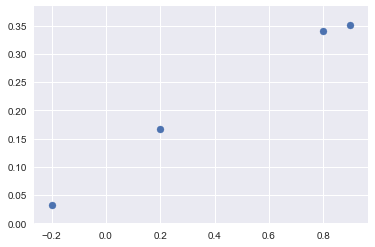

In [194]:
def get_num(ss):
    nn = ss.split()[-1]
    return float(nn[:-1]) if nn[-1] == '}' else float(nn)

    
ess = [
    get_num(fset_comparison['F%d' % i]['F%d' % (i - 1)])
    for i in range(2, 6)
]


mis = [
    mi.describe()[fset].T['mean'].max()
    for fset in feature_sets[1:]
]

plt.scatter(ess, mis)
stats.pearsonr(ess, mis)

## plot

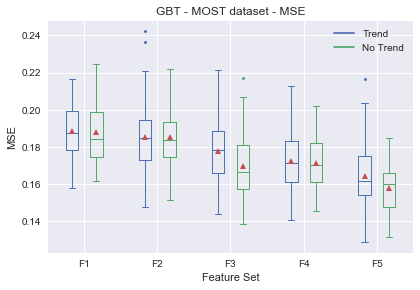

In [199]:
plt.show(make_base_plot(res, 'GBT', 'MOST', '0outercv', 'MSE',
                        show_baseline=False, plot_all=False, show_legend=True,
                        save_path='manuscript/images/fset_comparison.png' )[0])

## check normality

In [159]:
res[
    (res.Metric == 'MSE') &
    (res.Model != 'MOST') &
    (res.cvk == '0outercv') &
    (res.Model == 'GBT') &
    (res.Dataset == 'MOST') &
    (res.Trend == 'N')
].groupby('Features').apply(lambda g: pd.Series(
    stats.shapiro(g.value),
    index=['W', 'p']
))

,W,p
Features,,
F1,0.954389,0.051808
F2,0.973827,0.223651
F3,0.964738,0.140354
F4,0.977127,0.438174
F5,0.981368,0.610923


(0.01725150323000092, 0.18786334, 0.982010646954237)

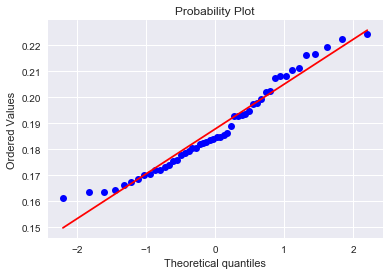

In [192]:
f1_vals = res[
    (res.Metric == 'MSE') &
    (res.Model != 'MOST') &
    (res.cvk == '0outercv') &
    (res.Model == 'GBT') &
    (res.Dataset == 'MOST') &
    (res.Trend == 'N') &
    (res.Features == 'F1')
].value
_, xx = stats.probplot(f1_vals, plot=plt)
xx

# generation of result tables

metrics for the MOST estimator

In [252]:
most_est_results = res[
    (res.Model == 'MOST')
].pivot_table(
    columns='Dataset',
    index='Metric',
    values='value',
    aggfunc=lambda g: '%.2f (%.2f)' % (g.mean(), g.std())
).reindex([  # change order of columns
    'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
])

df_to_latex(most_est_results, column_align='l|cc', fill_page_width=False,
            vertical_space=None, clear_index_name=False,
            save_to='manuscript/include/most_est_results.tex')

most_est_results

Dataset,Full,MOST
Metric,,
MSE,0.64 (0.04),0.32 (0.02)
$R^2$,0.71 (0.01),0.61 (0.01)
MAE,0.53 (0.01),0.39 (0.01)
mAE,0.37 (0.01),0.28 (0.01)
MAPE,257.80 (207.39),178.30 (68.99)
mAPE,28.48 (0.81),24.44 (0.81)


In [35]:
# one table for each estimator
for estimator in res.Model.unique():
    if estimator == 'MOST':
        continue

    est_res = res[
        (res.Model == estimator) &
        (res.cvk == '10outercv') &
        (res.is_latest == True)
    ].pivot_table(
        columns='Features',
        values='value',
        index=['Metric', 'Dataset', 'Trend'],
        aggfunc=lambda vals: table_newline('%.2f\n(%.2f)' % (vals.mean(), vals.std()))
    ).reindex([  # change order of columns
        'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
    ], level=0)
    
    print(estimator)
    display(est_res)
    
    df_to_latex(est_res, vertical_space='0.15ex', column_align='lcc|ccccc',
                save_to='manuscript/include/results_%s.tex' % estimator)

GBT


Features                                                F1  \
Metric Dataset Trend                                         
MSE    Full    N      \makecell[c]{0.50\\\relax(0.14)}       
               Y      \makecell[c]{0.47\\\relax(0.14)}       
       MOST    N      \makecell[c]{0.25\\\relax(0.09)}       
               Y      \makecell[c]{0.25\\\relax(0.11)}       
$R^2$  Full    N      \makecell[c]{0.78\\\relax(0.06)}       
               Y      \makecell[c]{0.79\\\relax(0.06)}       
       MOST    N      \makecell[c]{0.70\\\relax(0.12)}       
               Y      \makecell[c]{0.70\\\relax(0.13)}       
MAE    Full    N      \makecell[c]{0.43\\\relax(0.07)}       
               Y      \makecell[c]{0.40\\\relax(0.06)}       
       MOST    N      \makecell[c]{0.32\\\relax(0.08)}       
               Y      \makecell[c]{0.33\\\relax(0.08)}       
mAE    Full    N      \makecell[c]{0.26\\\relax(0.07)}       
               Y      \makecell[c]{0.22\\\relax(0.04)}       
       MOST    N      \makecell[c]{0.21\\\relax(0.08)}       
               Y      \makecell[c]{0.22\\\relax(0.08)}       
MAPE   Full    N      \makecell[c]{162.52\\\relax(104.39)}   
               Y      \makecell[c]{118.51\\\relax(60.72)}    
       MOST    N      \makecell[c]{106.73\\\relax(64.65)}    
               Y      \makecell[c]{111.10\\\relax(89.45)}    
mAPE   Full    N      \makecell[c]{21.98\\\relax(4.51)}      
               Y      \makecell[c]{19.33\\\relax(2.90)}      
       MOST    N      \makecell[c]{19.59\\\relax(5.58)}      
               Y      \makecell[c]{20.04\\\relax(6.06)}      

Features                                                F2  \
Metric Dataset Trend                                         
MSE    Full    N      \makecell[c]{0.46\\\relax(0.09)}       
               Y      \makecell[c]{0.44\\\relax(0.12)}       
       MOST    N      \makecell[c]{0.22\\\relax(0.06)}       
               Y      \makecell[c]{0.22\\\relax(0.07)}       
$R^2$  Full    N      \makecell[c]{0.79\\\relax(0.05)}       
               Y      \makecell[c]{0.80\\\relax(0.05)}       
       MOST    N      \makecell[c]{0.73\\\relax(0.07)}       
               Y      \makecell[c]{0.73\\\relax(0.09)}       
MAE    Full    N      \makecell[c]{0.41\\\relax(0.04)}       
               Y      \makecell[c]{0.40\\\relax(0.05)}       
       MOST    N      \makecell[c]{0.31\\\relax(0.04)}       
               Y      \makecell[c]{0.31\\\relax(0.06)}       
mAE    Full    N      \makecell[c]{0.24\\\relax(0.04)}       
               Y      \makecell[c]{0.22\\\relax(0.04)}       
       MOST    N      \makecell[c]{0.20\\\relax(0.03)}       
               Y      \makecell[c]{0.21\\\relax(0.06)}       
MAPE   Full    N      \makecell[c]{161.47\\\relax(128.93)}   
               Y      \makecell[c]{134.46\\\relax(106.10)}   
       MOST    N      \makecell[c]{112.76\\\relax(78.44)}    
               Y      \makecell[c]{108.63\\\relax(71.50)}    
mAPE   Full    N      \makecell[c]{20.60\\\relax(2.29)}      
               Y      \makecell[c]{19.49\\\relax(2.43)}      
       MOST    N      \makecell[c]{18.84\\\relax(2.90)}      
               Y      \makecell[c]{18.85\\\relax(4.49)}      

Features                                               F3  \
Metric Dataset Trend                                        
MSE    Full    N      \makecell[c]{0.43\\\relax(0.08)}      
               Y      \makecell[c]{0.49\\\relax(0.16)}      
       MOST    N      \makecell[c]{0.20\\\relax(0.04)}      
               Y      \makecell[c]{0.18\\\relax(0.01)}      
$R^2$  Full    N      \makecell[c]{0.81\\\relax(0.03)}      
               Y      \makecell[c]{0.78\\\relax(0.08)}      
       MOST    N      \makecell[c]{0.76\\\relax(0.05)}      
               Y      \makecell[c]{0.79\\\relax(0.01)}      
MAE    Full    N      \makecell[c]{0.39\\\relax(0.04)}      
               Y      \makecell[c]{0.41\\\relax(0.07)}      
       MOST    N      \makecell[c]{0.28\\\

kNN


Features                                                F1  \
Metric Dataset Trend                                         
MSE    Full    N      \makecell[c]{0.45\\\relax(0.05)}       
               Y      \makecell[c]{0.45\\\relax(0.02)}       
       MOST    N      \makecell[c]{0.22\\\relax(0.01)}       
               Y      \makecell[c]{0.23\\\relax(0.02)}       
$R^2$  Full    N      \makecell[c]{0.80\\\relax(0.01)}       
               Y      \makecell[c]{0.80\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.73\\\relax(0.01)}       
               Y      \makecell[c]{0.73\\\relax(0.01)}       
MAE    Full    N      \makecell[c]{0.41\\\relax(0.02)}       
               Y      \makecell[c]{0.41\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.31\\\relax(0.01)}       
               Y      \makecell[c]{0.31\\\relax(0.01)}       
mAE    Full    N      \makecell[c]{0.23\\\relax(0.01)}       
               Y      \makecell[c]{0.23\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.20\\\relax(0.01)}       
               Y      \makecell[c]{0.20\\\relax(0.01)}       
MAPE   Full    N      \makecell[c]{149.67\\\relax(128.39)}   
               Y      \makecell[c]{147.68\\\relax(95.02)}    
       MOST    N      \makecell[c]{110.32\\\relax(35.89)}    
               Y      \makecell[c]{110.71\\\relax(36.57)}    
mAPE   Full    N      \makecell[c]{20.25\\\relax(0.97)}      
               Y      \makecell[c]{20.28\\\relax(0.82)}      
       MOST    N      \makecell[c]{18.79\\\relax(0.65)}      
               Y      \makecell[c]{18.89\\\relax(0.95)}      

Features                                                F2  \
Metric Dataset Trend                                         
MSE    Full    N      \makecell[c]{0.48\\\relax(0.04)}       
               Y      \makecell[c]{0.48\\\relax(0.03)}       
       MOST    N      \makecell[c]{0.25\\\relax(0.01)}       
               Y      \makecell[c]{0.25\\\relax(0.02)}       
$R^2$  Full    N      \makecell[c]{0.79\\\relax(0.01)}       
               Y      \makecell[c]{0.79\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.70\\\relax(0.01)}       
               Y      \makecell[c]{0.70\\\relax(0.01)}       
MAE    Full    N      \makecell[c]{0.43\\\relax(0.02)}       
               Y      \makecell[c]{0.43\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.33\\\relax(0.01)}       
               Y      \makecell[c]{0.33\\\relax(0.01)}       
mAE    Full    N      \makecell[c]{0.25\\\relax(0.01)}       
               Y      \makecell[c]{0.25\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.22\\\relax(0.01)}       
               Y      \makecell[c]{0.22\\\relax(0.01)}       
MAPE   Full    N      \makecell[c]{162.01\\\relax(104.52)}   
               Y      \makecell[c]{176.15\\\relax(164.41)}   
       MOST    N      \makecell[c]{121.57\\\relax(54.94)}    
               Y      \makecell[c]{122.25\\\relax(44.17)}    
mAPE   Full    N      \makecell[c]{21.44\\\relax(1.09)}      
               Y      \makecell[c]{21.38\\\relax(0.89)}      
       MOST    N      \makecell[c]{20.18\\\relax(1.08)}      
               Y      \makecell[c]{20.14\\\relax(0.96)}      

Features                                               F3  \
Metric Dataset Trend                                        
MSE    Full    N      \makecell[c]{0.46\\\relax(0.04)}      
               Y      \makecell[c]{0.46\\\relax(0.03)}      
       MOST    N      \makecell[c]{0.24\\\relax(0.02)}      
               Y      \makecell[c]{0.24\\\relax(0.02)}      
$R^2$  Full    N      \makecell[c]{0.79\\\relax(0.01)}      
               Y      \makecell[c]{0.80\\\relax(0.01)}      
       MOST    N      \makecell[c]{0.71\\\relax(0.01)}      
               Y      \makecell[c]{0.71\\\relax(0.01)}      
MAE    Full    N      \makecell[c]{0.42\\\relax(0.02)}      
               Y      \makecell[c]{0.42\\\relax(0.02)}      
       MOST    N      \makecell[c]{0.32\\\

Ridge


Features                                                F1  \
Metric Dataset Trend                                         
MSE    Full    N      \makecell[c]{0.63\\\relax(0.05)}       
               Y      \makecell[c]{0.63\\\relax(0.05)}       
       MOST    N      \makecell[c]{0.27\\\relax(0.02)}       
               Y      \makecell[c]{0.27\\\relax(0.02)}       
$R^2$  Full    N      \makecell[c]{0.72\\\relax(0.02)}       
               Y      \makecell[c]{0.72\\\relax(0.02)}       
       MOST    N      \makecell[c]{0.67\\\relax(0.02)}       
               Y      \makecell[c]{0.67\\\relax(0.02)}       
MAE    Full    N      \makecell[c]{0.53\\\relax(0.02)}       
               Y      \makecell[c]{0.53\\\relax(0.02)}       
       MOST    N      \makecell[c]{0.36\\\relax(0.01)}       
               Y      \makecell[c]{0.36\\\relax(0.01)}       
mAE    Full    N      \makecell[c]{0.36\\\relax(0.01)}       
               Y      \makecell[c]{0.36\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.25\\\relax(0.01)}       
               Y      \makecell[c]{0.25\\\relax(0.01)}       
MAPE   Full    N      \makecell[c]{262.89\\\relax(258.33)}   
               Y      \makecell[c]{262.27\\\relax(271.17)}   
       MOST    N      \makecell[c]{137.37\\\relax(73.04)}    
               Y      \makecell[c]{139.18\\\relax(60.62)}    
mAPE   Full    N      \makecell[c]{29.27\\\relax(1.25)}      
               Y      \makecell[c]{29.28\\\relax(0.78)}      
       MOST    N      \makecell[c]{22.74\\\relax(0.77)}      
               Y      \makecell[c]{22.87\\\relax(1.63)}      

Features                                                F2  \
Metric Dataset Trend                                         
MSE    Full    N      \makecell[c]{0.63\\\relax(0.07)}       
               Y      \makecell[c]{0.63\\\relax(0.07)}       
       MOST    N      \makecell[c]{0.27\\\relax(0.03)}       
               Y      \makecell[c]{0.27\\\relax(0.02)}       
$R^2$  Full    N      \makecell[c]{0.72\\\relax(0.02)}       
               Y      \makecell[c]{0.72\\\relax(0.03)}       
       MOST    N      \makecell[c]{0.67\\\relax(0.03)}       
               Y      \makecell[c]{0.67\\\relax(0.01)}       
MAE    Full    N      \makecell[c]{0.53\\\relax(0.03)}       
               Y      \makecell[c]{0.53\\\relax(0.02)}       
       MOST    N      \makecell[c]{0.36\\\relax(0.02)}       
               Y      \makecell[c]{0.36\\\relax(0.01)}       
mAE    Full    N      \makecell[c]{0.36\\\relax(0.02)}       
               Y      \makecell[c]{0.36\\\relax(0.01)}       
       MOST    N      \makecell[c]{0.25\\\relax(0.01)}       
               Y      \makecell[c]{0.25\\\relax(0.01)}       
MAPE   Full    N      \makecell[c]{258.83\\\relax(235.59)}   
               Y      \makecell[c]{253.28\\\relax(222.37)}   
       MOST    N      \makecell[c]{138.23\\\relax(65.42)}    
               Y      \makecell[c]{139.73\\\relax(65.11)}    
mAPE   Full    N      \makecell[c]{29.30\\\relax(1.63)}      
               Y      \makecell[c]{29.34\\\relax(1.55)}      
       MOST    N      \makecell[c]{22.90\\\relax(1.46)}      
               Y      \makecell[c]{22.81\\\relax(0.85)}      

Features                                                F3  \
Metric Dataset Trend                                         
MSE    Full    N      \makecell[c]{0.62\\\relax(0.04)}       
               Y      \makecell[c]{0.63\\\relax(0.07)}       
       MOST    N      \makecell[c]{0.27\\\relax(0.02)}       
               Y      \makecell[c]{0.27\\\relax(0.01)}       
$R^2$  Full    N      \makecell[c]{0.72\\\relax(0.02)}       
               Y      \makecell[c]{0.72\\\relax(0.02)}       
       MOST    N      \makecell[c]{0.67\\\relax(0.02)}       
               Y      \makecell[c]{0.67\\\relax(0.02)}       
MAE    Full    N      \makecell[c]{0.52\\\relax(0.02)}       
               Y      \makecell[c]{0.52\\\relax(0.03)}       
       MOST    N      \makecel

# generation of parameters tables

In [190]:
renamed_paras = paras.replace({
    'value': {
        'distance': 'Dist.',
        'uniform': 'Unif.',
        'lad': 'LAD',
        'ls': 'LS',
        'huber': 'Hu',
    },
    'Metric': {
        'alpha': 'Alpha',
        'learning_rate': 'L.R.',
        'loss': 'Loss',
        'max_depth': 'Depth',
        'max_features': 'Feat.',
        'n_estimators': 'Trees',
        'n_neighbors': 'k',
        'p': 'Dist.',
        'regu': 'Reg.',
        'subsample': 'Subs.',
        'weights': 'Weight',
    }
}).rename(columns={
    'Metric': 'H.P.'
})

renamed_res = res[
    res.Metric == 'MSE'
].replace({
    'Metric': {'MSE': '(MSE)'}
}).rename(columns={
    'Metric': 'H.P.'
})


def make_table(model, dataset):
    def get_mask(df):
        return (
            (df.Model == model) &
            df.Features.isin(('f9', 'zL')) &
            (df.Dataset == dataset) &
            (df.cvk == '10outercv') &
            (df.is_latest) &
            df.Trend.isin(('N', '-'))
        )

    best_para_mask = get_mask(renamed_paras)
    best_res_mask = get_mask(renamed_res)

    # for GBt, alpha is only applicable with huber loss 
    def fix_gbt_params(row):
        if model == 'GBT' and row.Loss != 'Hu':
            row.Alpha = '-'
        return row
    
    # rename from metric to hyper-param, and replace MSE with (MSE)
    params_detail = pd.concat([
        renamed_paras[best_para_mask],
        renamed_res[best_res_mask]
    ]).sort_values(
        'H.P.'
    ).pivot_table(
        columns='Outer Fold',
        values='value',
        index='H.P.',
        aggfunc=lambda vals: vals.values[0]
    ).applymap(
        lambda x: '%.2f' % x if isinstance(x, float) else x
    )
    
    params_detail.T.apply(
        fix_gbt_params,
        axis=1
    )
    
    pad = (len(paras[best_para_mask].Metric.unique()) + 1)
    df_to_latex(params_detail, column_align='r|rrrrrrrrrr', multirow_pad='%dex' % pad,
                save_to='manuscript/include/params_%s_%s.tex' % (model.lower(), dataset.lower()),
                fill_page_width=True)

    print(model, dataset)
    display(params_detail)
    
    return params_detail


make_table('MOST', 'MOST')
make_table('MOST', 'Full')
make_table('Ridge', 'MOST')
make_table('GBT', 'Full')
det = make_table('GBT', 'MOST')

MOST MOST


Outer Fold,1,2,3,4,5,6,7,8,9,10
H.P.,,,,,,,,,,
(MSE),0.30,0.31,0.33,0.34,0.31,0.31,0.34,0.33,0.29,0.34
Reg.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


MOST Full


Outer Fold,1,2,3,4,5,6,7,8,9,10
H.P.,,,,,,,,,,
(MSE),0.63,0.58,0.63,0.60,0.62,0.63,0.67,0.71,0.64,0.64
Reg.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Ridge MOST


Outer Fold,1,2,3,4,5,6,7,8,9,10
H.P.,,,,,,,,,,
(MSE),0.30,0.29,0.28,0.28,0.28,0.28,0.26,0.24,0.24,0.28
Alpha,6.97,5.46,7.00,3.64,3.21,3.94,2.83,4.59,4.25,2.01


GBT Full


Outer Fold,1,2,3,4,5,6,7,8,9,10
H.P.,,,,,,,,,,
(MSE),0.31,0.36,0.37,0.42,0.37,0.33,0.40,0.34,0.32,0.40
Alpha,0.18,-,0.83,0.32,-,-,0.64,-,-,-
Depth,7,5,6,8,6,5,6,9,8,7
Feat.,0.99,0.66,0.88,0.24,0.77,0.94,0.44,0.69,0.84,0.39
L.R.,0.09,0.05,0.02,0.09,0.05,0.08,0.05,0.09,0.07,0.07
Loss,Hu,LS,Hu,Hu,LS,LS,Hu,LS,LS,LAD
Subs.,0.48,0.90,0.57,0.94,0.90,0.94,0.94,0.91,0.29,0.91
Trees,807,574,728,164,775,656,413,101,107,203


GBT MOST


Outer Fold,1,2,3,4,5,6,7,8,9,10
H.P.,,,,,,,,,,
(MSE),0.18,0.17,0.18,0.17,0.16,0.22,0.18,0.16,0.16,0.18
Alpha,0.22,-,-,0.38,-,0.10,-,-,0.44,0.71
Depth,8,7,8,7,7,4,8,9,7,5
Feat.,0.86,0.70,0.57,0.74,0.72,0.40,0.68,0.38,0.62,0.61
L.R.,0.07,0.10,0.03,0.10,0.07,0.05,0.05,0.05,0.10,0.05
Loss,Hu,LAD,LS,Hu,LS,Hu,LS,LAD,Hu,Hu
Subs.,0.28,0.85,0.74,0.83,0.55,0.54,0.47,0.56,0.30,0.62
Trees,447,425,738,327,622,276,294,235,941,692


# residuals of one model

In [203]:
res_file = 'results_GradientBoostingRegressor_f4_trend_most_10outercv-20180422-162014.txt'

with open('dev/results/' + res_file) as f:
    found = False
    for row in f:
        rr = row.strip()
        if rr.startswith('**raw json results'):
            found = True
        elif found and rr:
            data = rr
    assert found
    
    
import pickle, base64

try:
    import pyspark
except ImportError:
    import findspark
    findspark.init()
    import pyspark

pyspark  # must be imported or pickle won't load
    
cvres = pickle.loads(base64.b64decode(data), encoding='latin1')

In [204]:
np.mean(cvres.test_y - cvres.y_pred)

0.021018133820349852

In [205]:
np.mean((cvres.test_y - cvres.y_pred)**2)

0.1554791076287376

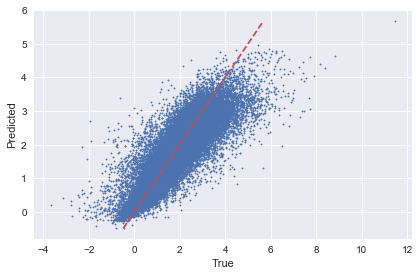

In [206]:
plt.scatter(cvres.test_y, cvres.y_pred, s=2)
x0 = max(min(cvres.test_y), min(cvres.y_pred))
x1 = min(max(cvres.test_y), max(cvres.y_pred))
plt.plot([x0, x1], [x0, x1], 'C2--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig('manuscript/images/residuals_scatter.png')

In [213]:
cvres.test_x.columns

Index(['wind', 'temp', 'soil_temp', 'z', 'dewpoint', 'rain', 'soilheat',
       'netrad', 'temp_10', 'temp_20', 'temp_40', 'wind_10', 'wind_20',
       'wind_40'],
      dtype='object')

In [220]:
np.mean(residuals**2), np.median(residuals**2)

(0.1554791076287376, 0.022738777007404447)

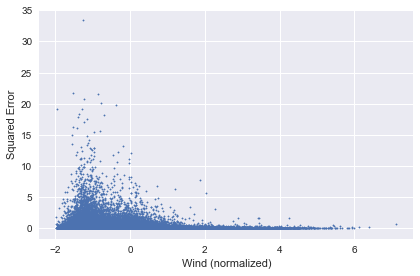

In [218]:
plt.scatter(cvres.test_x.wind, residuals**2, s=2)
plt.xlabel('Wind (normalized)')
plt.ylabel('Squared Error')
plt.tight_layout()
plt.savefig('manuscript/images/error_by_wind.png')

In [207]:
residuals = cvres.y_pred - cvres.test_y

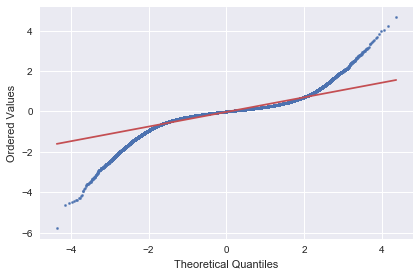

In [217]:
plt.figure()

(qx, qy), (m, q, r) = stats.probplot(residuals, plot=None, rvalue=True)
xmin, xmax = qx.min(), qx.max()

plt.scatter(qx, qy, s=5)
plt.plot([xmin, xmax], [m * xmin + q, m * xmax + q], 'C2')

plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('')
plt.tight_layout()
#plt.savefig('manuscript/images/residuals_probplot.png')

In [209]:
stats.shapiro(residuals)

C:\Users\edo\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.8499005436897278, 0.0)

In [210]:
r**2

0.8496693272030174

In [211]:
pd.DataFrame([
    residuals,
    np.abs(residuals),
    residuals**2,
], index=['res', 'abs_res', 'sq_res']).T.describe(percentiles=[
    .01, .025, .05, .1, .25, .5, .75, .9, .95, .975, .99
])

,res,abs_res,sq_res
count,107932.000000,1.079320e+05,1.079320e+05
mean,-0.021018,2.444295e-01,1.554791e-01
std,0.393750,3.094094e-01,6.039350e-01
min,-5.782332,1.477623e-08,2.183370e-16
1%,-1.350155,2.625905e-03,6.895385e-06
2.5%,-0.897432,6.526195e-03,4.259123e-05
5%,-0.604910,1.305787e-02,1.705081e-04
10%,-0.386225,2.594043e-02,6.729058e-04
25%,-0.158760,6.732072e-02,4.532079e-03
50%,0.003423,1.507938e-01,2.273878e-02


In [212]:
sum(residuals**2 > np.mean(residuals**2)) / len(residuals)

0.1694863432531594